In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import visualize_population_curves_attacked,visualize_individual_curves_attacked

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=100
args.lr = 1e-3
args.batch_size= 128
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=10,length=20"
args.hidden_dims = [15,15]
args.save_model = ""
args.dataset = "TRACE"


In [4]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [5]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [6]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [7]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))


# model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(RightCensorWrapper(clf_robust),dataset_train.tensors)
model_fragile_wrap = BoundedModule(RightCensorWrapper(clf_fragile),dataset_train.tensors)

In [8]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=664.4152 Time=0.0031
[ 1:  10]: eps=0.00000000 Loss=653.5763 Time=0.0020
[ 1:  11]: eps=0.00000000 Loss=640.2246 Time=0.0019
Epoch time: 0.0316, Total time: 0.0316
Evaluating...
[ 1:   2]: eps=0.00000000 Loss=618.9241 Time=0.0013
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=590.7852 Time=0.0020
[ 2:  10]: eps=0.00000000 Loss=599.3054 Time=0.0019
[ 2:  11]: eps=0.00000000 Loss=589.6128 Time=0.0019
Epoch time: 0.0300, Total time: 0.0616
Evaluating...
[ 2:   2]: eps=0.00000000 Loss=568.7746 Time=0.0010
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=611.7075 Time=0.0020
[ 3:  10]: eps=0.00000000 Loss=545.6740 Time=0.0018
[ 3:  11]: eps=0.00000000 Loss=538.7748 Time=0.0017
Epoch time: 0.0285, Total time: 0.0901
Evaluating...
[ 3:   2]: eps=0.00000000 Loss=516.3059 Time=0.0010
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=531.0488 Time=0.0020
[ 4:  10]: eps=0.00000000 Loss=497.7436 T

In [9]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=664.4152 Time=0.0020
[ 1:  10]: eps=0.00000000 Loss=653.5763 Time=0.0020
[ 1:  11]: eps=0.00000000 Loss=640.2246 Time=0.0019
Epoch time: 0.0336, Total time: 0.0336
Evaluating...
[ 1:   2]: eps=0.00000000 Loss=618.9241 Time=0.0010
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=590.7852 Time=0.0010
[ 2:  10]: eps=0.00000000 Loss=599.3054 Time=0.0022
[ 2:  11]: eps=0.00000000 Loss=589.6128 Time=0.0021
Epoch time: 0.0357, Total time: 0.0693
Evaluating...
[ 2:   2]: eps=0.00000000 Loss=568.7746 Time=0.0010
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=611.7075 Time=0.0050
[ 3:  10]: eps=0.00000000 Loss=545.6740 Time=0.0023
[ 3:  11]: eps=0.00000000 Loss=538.7748 Time=0.0022
Epoch time: 0.0386, Total time: 0.1080
Evaluating...
[ 3:   2]: eps=0.00000000 Loss=516.3059 Time=0.0020
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=531.0488 Time=0.0040
[ 4:  10]: eps=0.00000000 Loss=497.7436 T

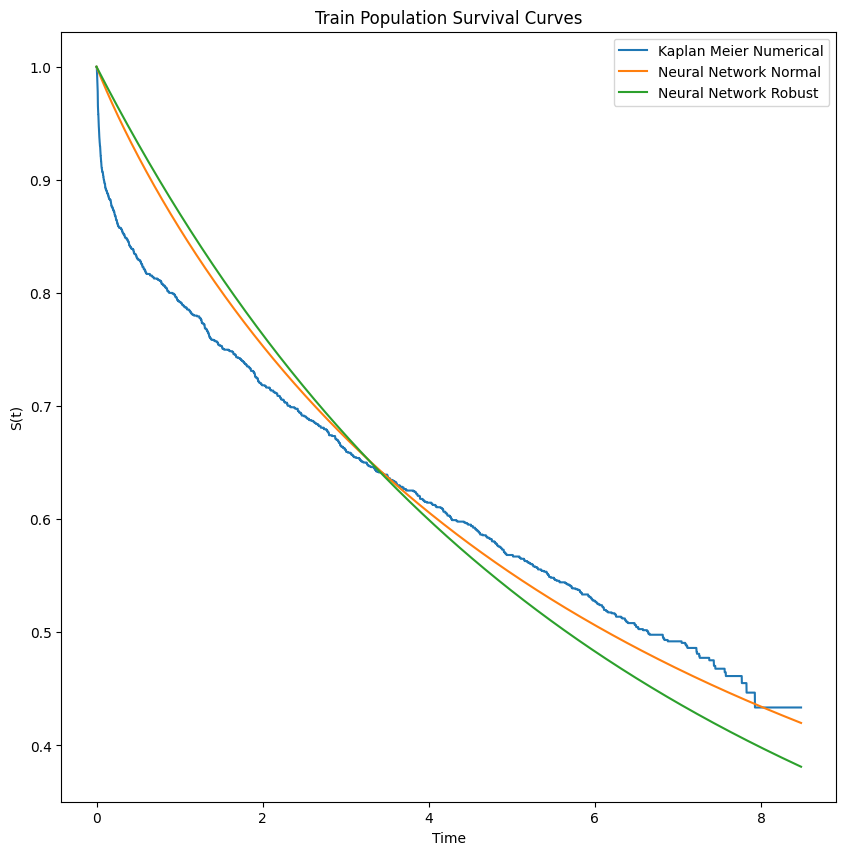

In [10]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_fragile_x.mean(0))
plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.show()

<Figure size 1000x1000 with 0 Axes>

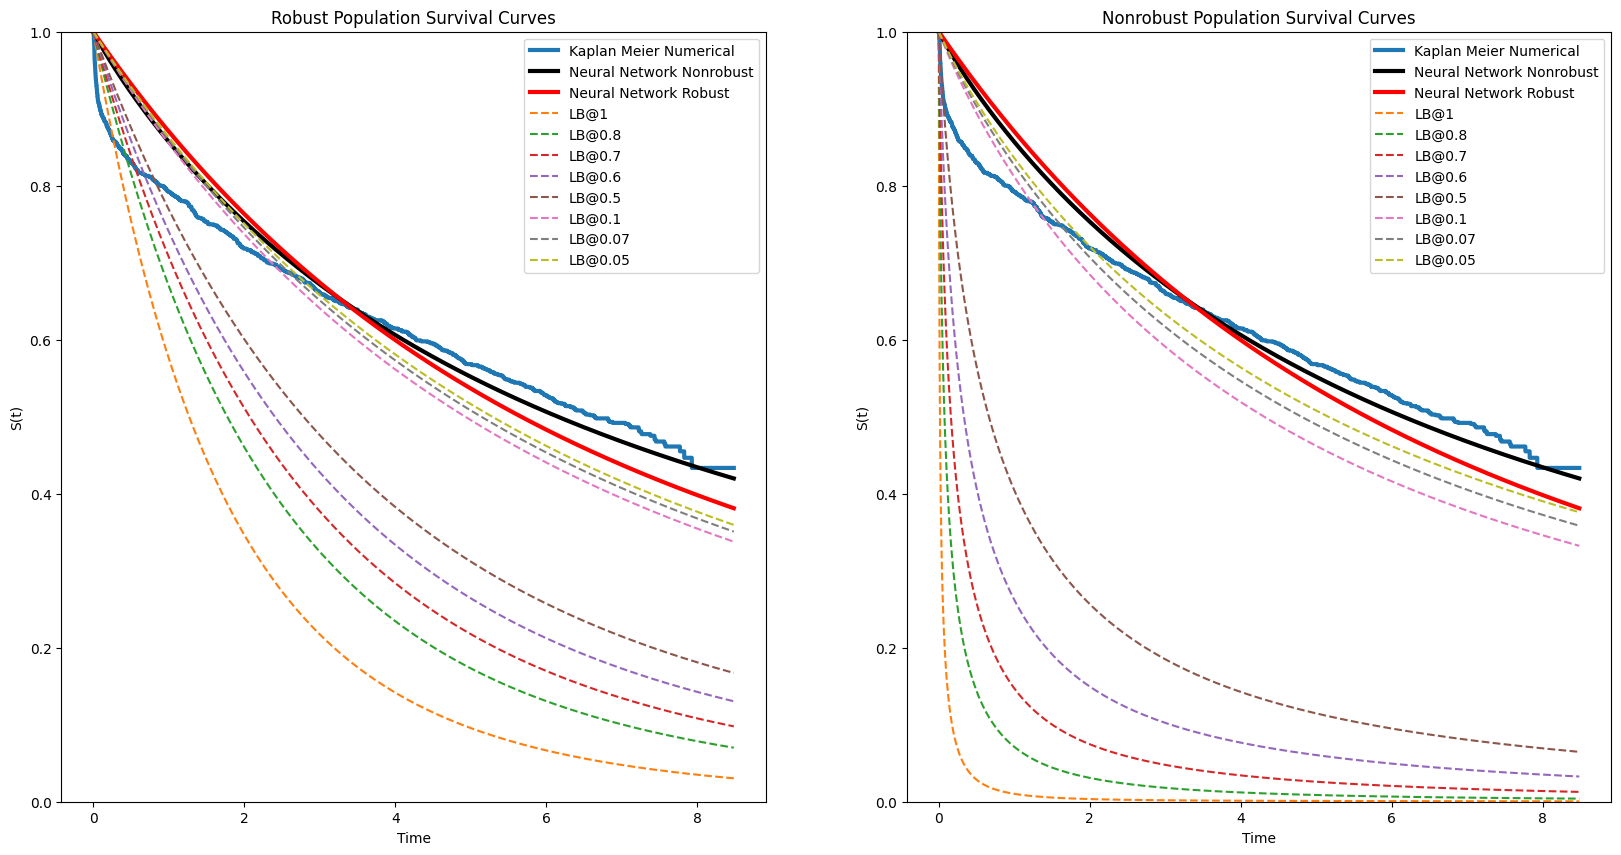

In [11]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)

<Figure size 1000x1000 with 0 Axes>

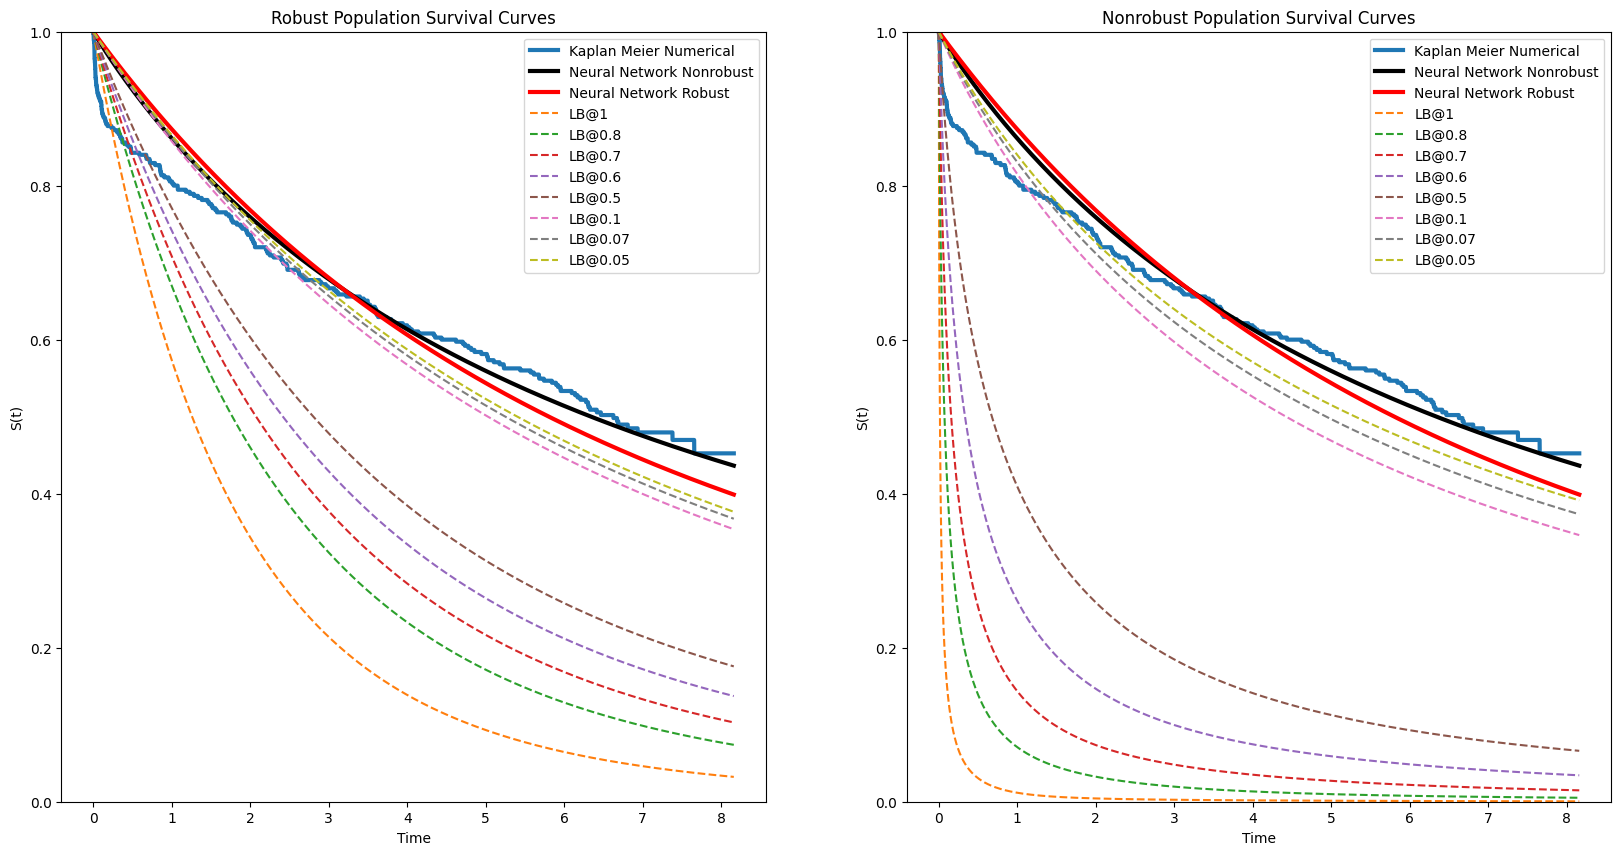

In [12]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

tensor([2.9584, 3.4801, 4.0019, 4.0105, 4.1914, 4.2248, 4.3664, 4.4073, 4.4123,
        4.4193])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


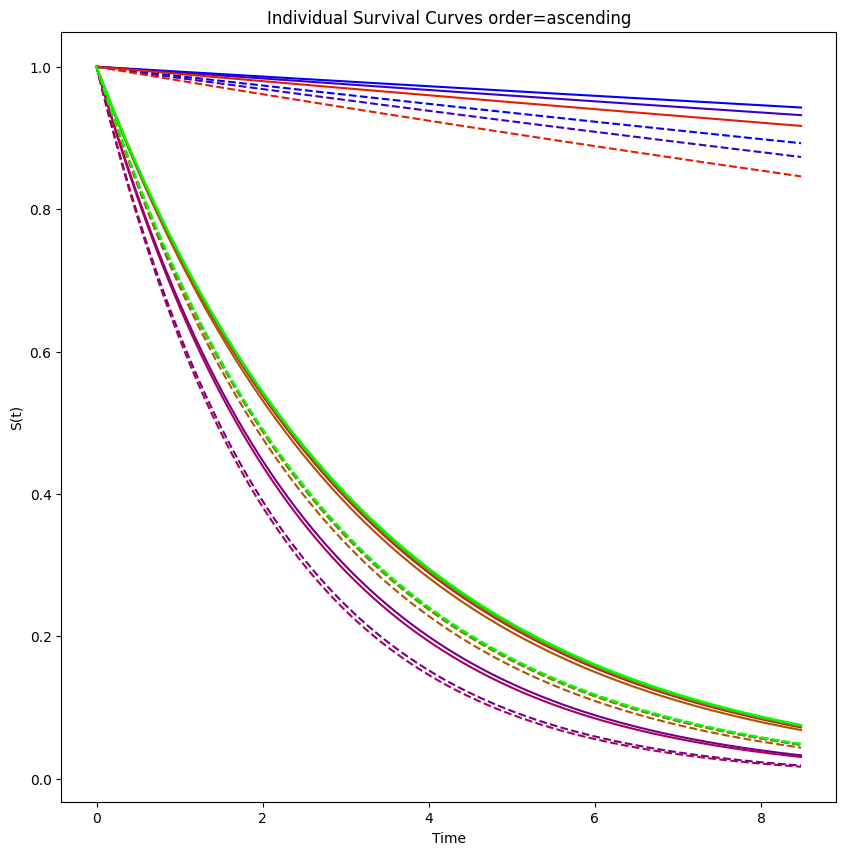

In [13]:
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=0.3,order="ascending")

tensor([19.2114, 19.1369, 19.0711, 19.0355, 19.0126, 18.9994, 18.9709, 18.9669,
        18.9569, 18.9297])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]


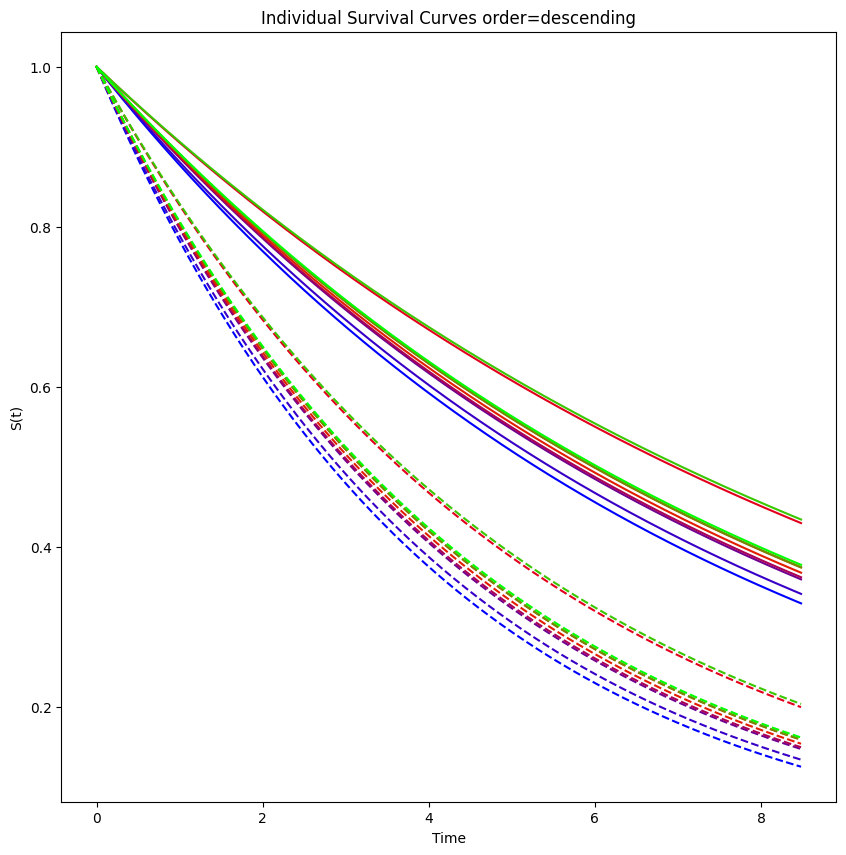

In [14]:
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=0.3,order="descending")

tensor([3.8150, 4.2436, 4.4392, 4.4419, 4.4601, 4.4916, 5.1969, 5.7512, 5.8027,
        6.1840])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.87it/s]


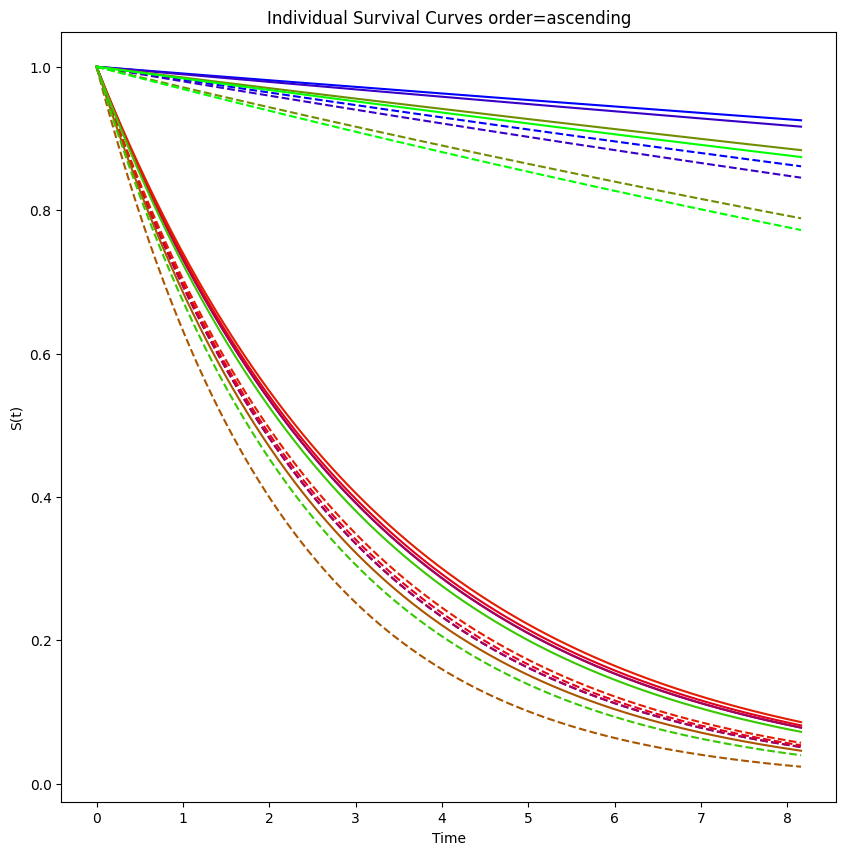

In [15]:
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=0.3,order="ascending")

tensor([19.2930, 18.8429, 18.7673, 18.7158, 18.4371, 18.3871, 18.3262, 18.3158,
        18.2119, 18.1209])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.93it/s]


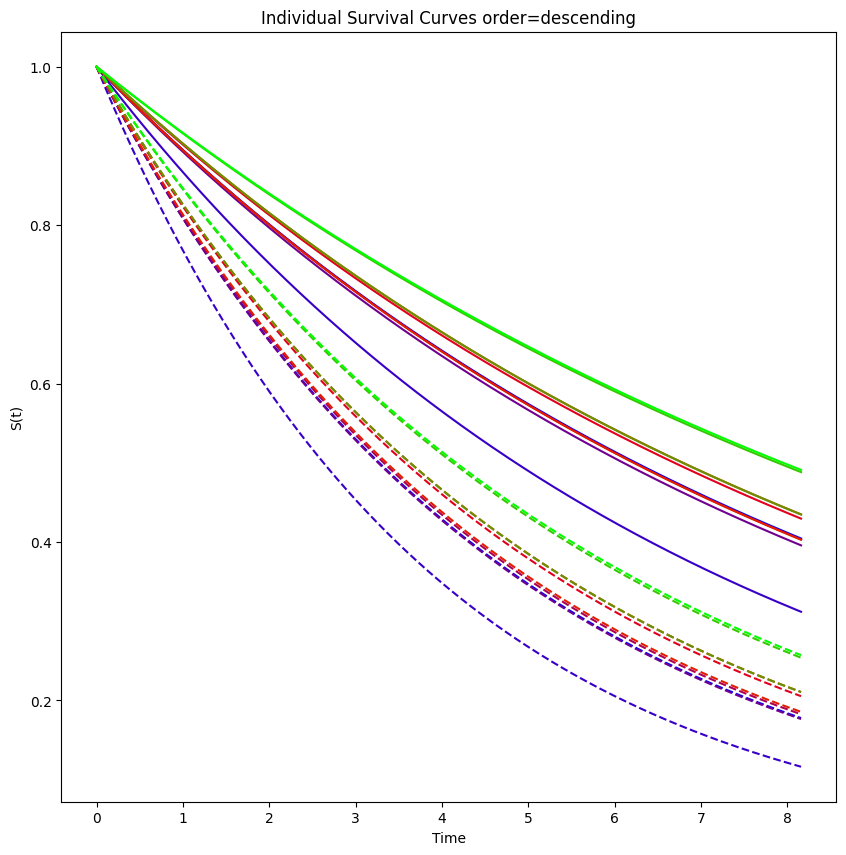

In [16]:
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=0.3,order="descending")